In [1]:
%reload_ext autoreload
%autoreload 2

# Test optimization of minimization of $\log^2x$

In [ ]:
import tensorflow as tf

x = tf.Variable(2, name='x', dtype=tf.float32)
log_x = tf.log(x)
log_x_squared = tf.square(log_x)


optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(log_x_squared)

init = tf.global_variables_initializer()

def optimize():
    with tf.Session() as session:
        session.run(init)
        print("starting at", "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))
        for step in range(10):  
          session.run(train)
          print("step", step, "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))
            
optimize()

# Test optimization of minimization of $x^2$

In [ ]:
import tensorflow as tf

from tensorflow.python.framework import ops
ops.reset_default_graph()

x = tf.Variable(2, name='x', dtype=tf.float32)
def xx():
    return tf.square(x)

optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(tf.py_func(xx,[x],tf.float32))

init = tf.global_variables_initializer()

def optimize():
    with tf.Session() as session:
        session.run(init)
        print("starting at", "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))
        for step in range(10):  
            session.run(train)
              print("step", step, "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))
            
optimize()

# Train the Erdos-Renyi model

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import with_statement

import sys
sys.path.append('..')

import tensorflow as tf
import networkx as nx

import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns

from networkqit import graph_laplacian as GL
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

########## INITIALIZATION PHASE ##########
N = 100
pstar = 0.2
beta = 0.001
shape=[N, N]
G = nx.erdos_renyi_graph(N,pstar)
A = nx.to_numpy_array(G)
print('Empirical density:', nx.density(G))
L=nq.graph_laplacian(A)
rho = nq.compute_vonneuman_density(L=L,beta=beta)
lo = np.linalg.eigvalsh(L)

########## TENSORFLOW PHASE ##########
with tf.device('/device:GPU:0'):
    # Define the tensorflow optimization variable p
    p = tf.Variable(float(np.random.random()), name='p')
    
    # Convert stuff to tensorflow to create nodes in the computational graph
    beta=tf.convert_to_tensor(beta,name='beta',dtype=tf.float32)
    rho = tf.convert_to_tensor(rho,name='rho',dtype=tf.float32)
    Lobs = tf.convert_to_tensor(L,name='Lobs',dtype=tf.float32)
    lo = tf.convert_to_tensor(lo,dtype=tf.float32)
    
    # Create the sampling matrix
    rij = tf.random_uniform(shape,minval=0.0,maxval=1.0)
    rijsym = (tf.transpose(rij) + rij) / 2.0
    pij = tf.multiply(rijsym,tf.ones([N,N])-tf.eye(N))
    
    # Sample from the probabilities
    Amodel = 1/(1 + tf.exp(40*pij-40*p)) # this is like setting Amodel = pij > p as the sigmoid is similar 
    Amodel = tf.multiply(Amodel,tf.constant([1.0]) - tf.eye(shape[0])) # set the diagonal to zero
    model_density = tf.reduce_sum(Amodel) / (N * (N - 1))
    
    Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel
    Em = tf.reduce_sum(tf.multiply(Lmodel,rho))
    # Observation energy
    Eo = tf.reduce_sum(tf.multiply(Lobs,rho))
    # Model laplacian eigenvalues
    lm = tf.self_adjoint_eig(Lmodel)[0]
    # Observation laplacian eigenvalues
    #lo = tf.self_adjoint_eig(Lobs)[0]
    # Model free energy
    Fm = - tf.reduce_logsumexp(-beta*lm) / beta
    # Observation free energy
    Fo = - tf.reduce_logsumexp(-beta*lo) / beta
    # Model loglikelihood
    loglike = beta*(-Fm + Em)
    # Observation entropy
    entropy = beta*(-Fo + Eo)
    # Model relative entropy (using abs for precision purposes)
    rel_entropy = tf.abs(loglike - entropy)
    grad = tf.gradients(rel_entropy,p)

    # Define the optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    # Define the function to start optimization
    train = optimizer.minimize(rel_entropy)
    # Initialize the global variables
    #print(tf.trainable_variables())
    init = tf.global_variables_initializer()

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        session.run(init)
        all_loss,all_theta = [],[]
        epochs = 10
        print('Initial p:', session.run(p))
        for step in range(epochs):
            session.run(train)
            all_theta.append(session.run(model_density))
            all_loss.append(session.run(rel_entropy))
            g = session.run(grad)
            print('\r beta:',session.run(beta), 'step', step, 'p:',all_theta[-1],  'density:',session.run(model_density), 'loss:', all_loss[-1],'grad:',g, end='')

        plt.figure(figsize=(8,8))
        plt.imshow(session.run(1-Amodel),cmap='binary')
        plt.grid(False)
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
        ax[0].plot(all_loss)
        ax[1].plot(all_theta)
        ax[1].plot([pstar]*len(all_theta),'r-')
        plt.tight_layout()

# Train the configuration model

In [29]:
sess_id=0

In [32]:
nx.planted_partition_graph?

Signature: nx.planted_partition_graph(l, k, p_in, p_out, seed=None, directed=False)
Docstring:
Return the planted l-partition graph.

This model partitions a graph with n=l*k vertices in
l groups with k vertices each. Vertices of the same
group are linked with a probability p_in, and vertices
of different groups are linked with probability p_out.

Parameters
----------
l : int
  Number of groups
k : int
  Number of vertices in each group
p_in : float
  probability of connecting vertices within a group
p_out : float
  probability of connected vertices between groups
seed : int,optional
  Seed for random number generator(default=None)
directed : bool,optional (default=False)
  If True return a directed graph

Returns
-------
G : NetworkX Graph or DiGraph
  planted l-partition graph

Raises
------
NetworkXError:
  If p_in,p_out are not in [0,1] or

Examples
--------
>>> G = nx.planted_partition_graph(4, 3, 0.5, 0.1,seed=42)

See Also
--------
random_partition_model

References
----------


[<tf.Variable 'model/xi:0' shape=(400,) dtype=float32_ref>]
 beta: 0.001 step 999 density: 0.24915937 deltam: -285.10156 loss: 4.339218e-05

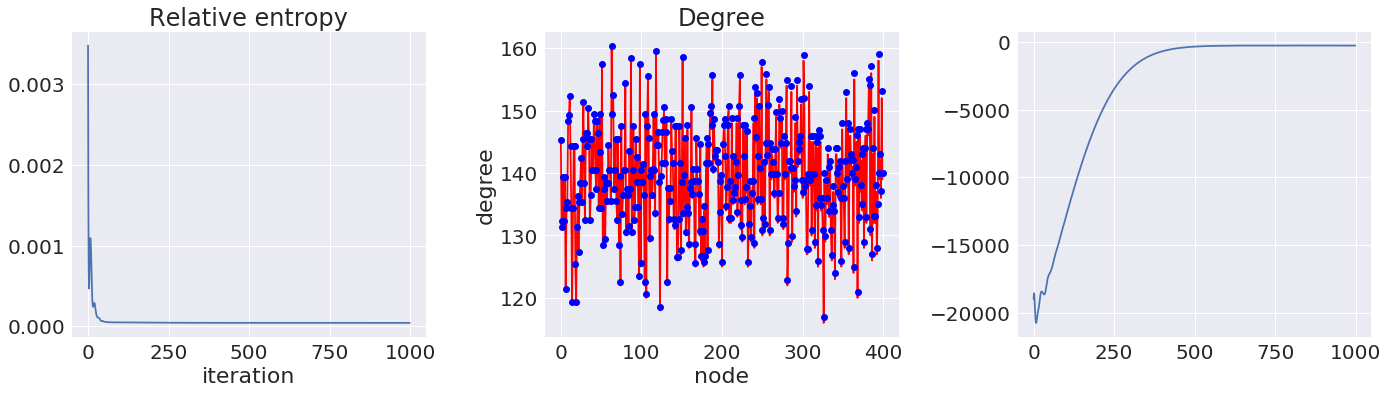

In [35]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import with_statement

import sys
sys.path.append('..')

import tensorflow as tf
import networkx as nx

import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

tf.logging.set_verbosity(tf.logging.INFO)
sns.set(font_scale=2)
sess_id+=1
tf.reset_default_graph()
g = tf.Graph()
with g.as_default(), tf.device('/device:CPU:0'), tf.name_scope('model'):
    # Define the observed matrix (using the karate club)
    N = 50
    pstar = 0.2
    beta = 1E-3
    G = nx.erdos_renyi_graph(N,pstar)
    G = nx.karate_club_graph()
    G = nx.planted_partition_graph(4,100,0.8,0.2)
    N=len(G.nodes())
    A = nx.to_numpy_array(G)
    shape=[N, N]
    m = A.sum()
    L=np.diag(A.sum(axis=0))-A
    rho = nq.compute_vonneuman_density(L=L,beta=beta)
    
    # Convert stuff to tensorflow to create nodes in the computational graph
    beta=tf.convert_to_tensor(beta,name='beta',dtype=tf.float32)
    rho = tf.convert_to_tensor(rho,name='rho',dtype=tf.float32)
    Lobs = tf.convert_to_tensor(L,name='Lobs',dtype=tf.float32)
    
    # Define the tensorflow optimization variable x
    xi = tf.Variable(tf.random_uniform(shape=[N,]), name='xi')
    # sampling phase, create the sampled matrix Amodel
    s1 = tf.random_uniform(shape,minval=0.0, maxval=1.0)
    s2 = (tf.transpose(s1)+s1) / 2.0
    s3 = tf.multiply(s2,tf.constant([1.0])-tf.eye(shape[0]))
    xij = tf.einsum('i,j->ij',xi,xi) # outer product 
    Amodel = xij / (1.0 + xij)
    Amodel = 1.0 / (1.0 + tf.exp(100*s3-100*xi)) # this is like setting < to 0 and > to 1
    #Amodel = tf.multiply(Amodel,tf.constant([1.0])-tf.eye(shape[0])) # set diagonal to zero
    # Compute the model density
    model_density = tf.reduce_sum(Amodel)/(N * (N-1))
    #Amodel = bernoulli_adj(p,[N,N])
    #Amodel = tf.distributions.Bernoulli(probs=tf.constant(p,shape=[N,N]))
    Amodel = tf.multiply(xi,1-tf.eye(N))
    Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel
    deltaL = m - tf.reduce_sum(Amodel)
    # Model energy
    with tf.name_scope('thermodynamics'):
        Em = tf.reduce_sum(tf.multiply(Lmodel,rho))
        # Observation energy
        Eo = tf.reduce_sum(tf.multiply(Lobs,rho))
        # Model laplacian eigenvalues
        lm = tf.self_adjoint_eig(Lmodel)[0]
        # Observation laplacian eigenvalues
        lo = tf.self_adjoint_eig(Lobs)[0]
        # Model free energy
        Fm = -tf.reduce_logsumexp(-beta*lm) / beta
        # Observation free energy
        Fo = -tf.reduce_logsumexp(-beta*lo) / beta

        loglike = beta*(-Fm + Em)
        entropy = beta*(-Fo + Eo)
        rel_entropy = tf.abs(loglike - entropy)
        grad = tf.gradients(rel_entropy,xi)

    # Define the optimizer
    train = tf.train.AdamOptimizer(learning_rate=0.1).minimize(rel_entropy)
    # Initialize the global variables
    print(tf.trainable_variables())
    init = tf.global_variables_initializer()
    # Create a summary to monitor cost tensor
    tf.summary.scalar('loss_logger', rel_entropy)
    tf.summary.scalar('deltam_logger', deltaL)
    tf.summary.histogram('xi_logger',xi)
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()

    # Run the computational graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        # op to write logs to Tensorboard
        writer = tf.summary.FileWriter('/home/carlo/workspace/networkqit/tensorboard/'+str(sess_id), session.graph)
        session.run(init)
        all_loss,alldeltaL = [], []
        epochs = 1000
        ##### Start the training
        for step in range(epochs):
            ########## Tensorflow logging ##########
            session.run(train)
            summary = session.run(merged_summary_op)
            #print(summary,step)
            writer.add_summary(summary, step)
            
            ####### Matplotlib logging #######
            all_loss.append(session.run(rel_entropy))
            alldeltaL.append(session.run(deltaL))
            # Write logs at every iteration
            #summary_writer.add_summary(summary, step )
            writer.flush()
            print('\r beta:',session.run(beta), 'step', step,  'density:',session.run(model_density), 'deltam:', session.run(deltaL) ,'loss:', all_loss[-1],end='')
        writer.close()
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
        ax[0].plot(all_loss)
        ax[0].set_title('Relative entropy')
        ax[0].set_xlabel('iteration')
        ax[1].plot(A.sum(axis=0),'r-')
        ax[1].set_title('Degree')
        ax[1].set_xlabel('node')
        ax[1].set_ylabel('degree')
        ax[1].plot(session.run(Amodel).sum(axis=0),'bo')
        ax[2].plot(alldeltaL)
        plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x=np.random.random(1000)
p=0.8
plt.plot(x,1/(1+np.exp(-50*x+50*p)),'.')
plt.plot(x,(p<x).astype(float),'r.')
plt.plot(x,x>p,'g.')
plt.show()

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type=='CPU']
get_available_devices()

In [ ]:
# Creates a graph.
import tensorflow as tf
with tf.device('/device:GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the ops.
print(sess.run(c))